# Inference

In [1]:
import pickle 
import joblib 
import matplotlib.pyplot as plt
history = joblib.load('../logs/history.pkl')
import pandas as pd
import numpy as np
import torch
import sys
sys.path.append('../')
from model import *

In [20]:
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]


In [21]:
train_loss = history['train'][0]['train_loss']
len(train_loss)

3000

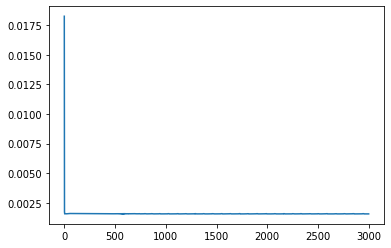

In [22]:
plt.plot(range(len(train_loss)), train_loss)

In [23]:
valid_loss = history['valid'][0]['valid_loss']
len(valid_loss)

3000

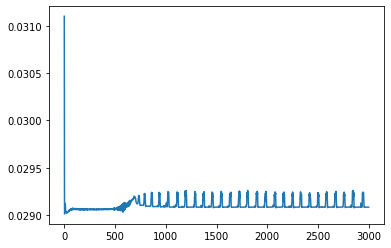

In [24]:
plt.plot(range(len(valid_loss)), valid_loss)

In [25]:
# train config

hidden_size = 32
output_window=28
input_window=50
target_len = output_window
target_feature = 'open'

In [26]:
df = pd.read_csv('../dataset/upbit_ohlcv_1700.csv')

scaler = joblib.load('../logs/scaler.pkl')

pred_tmp = np.array(df.iloc[-(input_window + target_len):-target_len, :][target_feature])
pred_tmp = difference(pred_tmp, 1)
pred = np.array(pred_tmp)

pred = pred.reshape(-1,1)
pred_std = scaler.transform(pred)

model = seq2seq(1, hidden_size, output_window)
model.load_state_dict(torch.load('../logs/model.pth'))

<All keys matched successfully>

In [27]:
predict = model.predict(torch.tensor(pred_std).float())

predict = scaler.inverse_transform(predict.reshape(-1,1))

In [28]:
# inverse difference transform 
orignal_data = np.array(df.iloc[-(input_window + target_len):-target_len, :][target_feature])

predict_flat = predict.flatten()
orig_pred = np.concatenate([orignal_data, predict_flat])

time_diff = 1
inv_pred = np.zeros((28))
for index in range(28):
    inv_pred[index] = orig_pred[50+index]+orig_pred[50+index-time_diff]
    orig_pred[50+index] = inv_pred[index]

inv_pred

array([48738417.23046875, 48758834.4609375 , 48779251.69140625,
       48799668.921875  , 48820086.15234375, 48840503.3828125 ,
       48860920.61328125, 48881337.84375   , 48901755.07421875,
       48922172.3046875 , 48942589.53515625, 48963006.765625  ,
       48983423.99609375, 49003841.2265625 , 49024258.45703125,
       49044675.6875    , 49065092.91796875, 49085510.1484375 ,
       49105927.37890625, 49126344.609375  , 49146761.83984375,
       49167179.0703125 , 49187596.30078125, 49208013.53125   ,
       49228430.76171875, 49248847.9921875 , 49269265.22265625,
       49289682.453125  ])

In [29]:
real = df[target_feature].to_numpy()

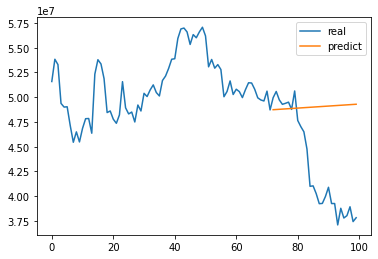

In [30]:
plt.plot(range(100), real[-100:], label='real')
plt.plot(range(100-target_len, 100), inv_pred, label='predict')

plt.legend()
plt.show()

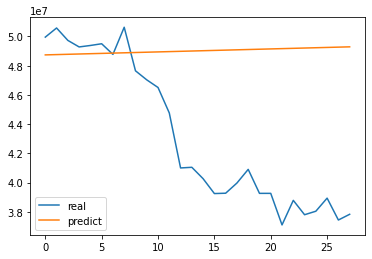

In [33]:
plt.plot(range(28), real[-28:], label='real')
plt.plot(range(28), inv_pred, label='predict')

plt.legend()
plt.show()

In [31]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [32]:
MAPEval(inv_pred, real[-28:].reshape(-1,1))

15.726806746692231